In [75]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [76]:
ee.Initialize()

In [77]:
from channel_classifier.internal.ee_utils import add_labels, compute_error_image, get_landsat_images, get_landsat_composite
from channel_classifier.internal.utils import download_rgb_image, download_tiff

In [165]:
def ndvi_l5(image):
    return image.normalizedDifference(['B4', 'B3']).rename(['NDVI'])

def ndvi_l8(image):
    return image.normalizedDifference(['B5', 'B4']).rename(['NDVI'])

In [236]:
path, row = [3, 69] # RMDD
bbox1 = [-70.67, -13.05, -70.38, -12.99]
bbox2 = [-70.73, -13.14, -70.48, -13.09]
start_date = '1984-01-01'
end_date = '2018-01-01'

In [237]:
region = ee.Geometry.Rectangle(bbox1)
background = ee.Geometry.Rectangle(bbox2)

def set_mean(image):
    d = image.reduceRegion(ee.Reducer.mean(), region)
    return image.set(d)
  
def set_background(image):
    d = image.reduceRegion(ee.Reducer.mean(), background)
    return image.set(d)

                NDVI
1984-12-31  0.352201
1985-12-31  0.325443
1986-12-31  0.319854
1987-12-31  0.473766
1988-12-31  0.084142
1989-12-31  0.357538
1990-12-31  0.378081
1991-12-31  0.269984
1992-12-31  0.242948
1993-12-31  0.525308
1994-12-31  0.134761
1995-12-31  0.194355
1996-12-31  0.334361
1997-12-31  0.445641
1998-12-31  0.309315
1999-12-31  0.344709
2000-12-31  0.408675
2001-12-31  0.345769
2002-12-31  0.508647
2003-12-31  0.243526
2004-12-31  0.337097
2005-12-31  0.367972
2006-12-31  0.391959
2007-12-31  0.278071
2008-12-31  0.305201
2009-12-31  0.278253
2010-12-31  0.339599
2011-12-31  0.364113


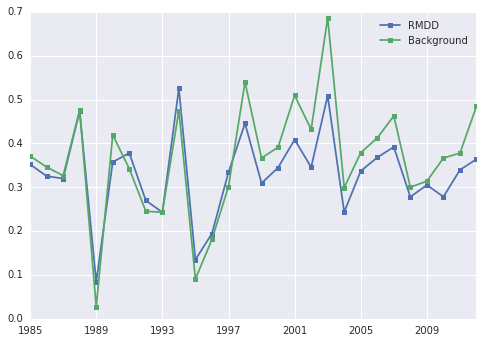

In [257]:
fig, ax = plt.subplots(1,1)

images = ee.ImageCollection([])
ndvis = ee.ImageCollection([])
datasets = ['LANDSAT/LT05/C01/T1_TOA'] #, 'LANDSAT/LE07/C01/T1_TOA', 'LANDSAT/LC08/C01/T1_TOA']
functions = [ndvi_l5] #, ndvi_l5, ndvi_l8]
for dataset, ndvi in zip(datasets, functions):
    x = get_landsat_images(path, row, start_date, end_date, dataset_path=dataset)
    x = x.filter(ee.Filter.lt('CLOUD_COVER', 50))
    images = ee.ImageCollection(x)
    ndvis = images.map(ndvi).map(set_mean)
    control = images.map(ndvi).map(set_background)
    dates = images.aggregate_array('system:time_start').getInfo()
    y1 = ndvis.aggregate_array('NDVI').getInfo()
    y2 = control.aggregate_array('NDVI').getInfo()
    if len(y1) > 0:
        dates = pd.to_datetime(dates, unit='ms')
        data1 = pd.DataFrame({'NDVI' : y1}, index=dates)
        data2 = pd.DataFrame({'NDVI' : y2}, index=dates)
        data1 = data1.groupby(pd.TimeGrouper('A')).mean()
        data2 = data2.groupby(pd.TimeGrouper('A')).mean()
        print(data1)
        ax.plot(data1.index, data1['NDVI'], data2.index, data2['NDVI'], marker='s', markersize=5)
plt.legend(['RMDD', 'Background'])